In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn

import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import os
# from tensorflow.keras.models import load_model

# from tensorflow.keras.models import Model
import os
import warnings


from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset



/home/csgrad/byalavar/miniconda3/envs/train/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.gender_mapping = {'M': 0, 'F': 1}
        self.ethnicity_mapping = {'A': 0, 'B': 1, 'L': 2, 'W': 3}


    def __len__(self):
        return len(self.data)


        
    def getAgeLabel(self,value1):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        if(class_ranges[0][0]<=value1 and value1<class_ranges[0][1]):
            return 0
        elif(class_ranges[1][0]<=value1 and value1<class_ranges[1][1]):
            return 1
        elif(class_ranges[2][0]<=value1 and value1<class_ranges[2][1]):
            return 2
        elif(class_ranges[3][0]<=value1 and value1<class_ranges[3][1]):
            return 3
        else:
            return 0

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        folder_path  = '/home/csgrad/byalavar/chicagoFace/CFD Version 3.0/Images/CFD/'+row['Model'] # Assuming images are in a folder named 'images'
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
        image_file_path = os.path.join(folder_path, image_files[0])
    

        image = Image.open(image_file_path)
        age = row['AgeRated']
        
        if(row['AgeRated']<=0):
            age=35
        label = {
            'age': self.getAgeLabel(age),
            'gender': self.gender_mapping.get(row['GenderSelf'], 0),  # -1 for unknown
            'ethnicity': self.ethnicity_mapping.get(row['EthnicitySelf'], 0)
        
        }
        #print(row['name'])
        if self.transform:
            image = self.transform(image)

        return image, label




In [3]:
# csv_file = '/home/csgrad/byalavar/FHE/celebSet/celebSET_final_v1.csv'  # Replace with the actual path to your CSV file
# df = pd.read_csv(csv_file)

# # Create a list to store the indices of rows with missing files
# rows_to_remove = []
# count=0
# # Iterate through the DataFrame and check if the files exist
# for index, row in df.iterrows():
#     image_path = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/'+row['name']+'/' + row['filename'] 
#     if not os.path.exists(image_path):
#         rows_to_remove.append(index)
#         count=count+1
# df = df.drop(rows_to_remove)
# df.to_csv(csv_file, index=False)
# print(count)

In [3]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize the image to the desired size
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

transformAugment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    
])

transformAugment2 = transforms.Compose([
    transforms.RandomPerspective(),
    transforms.RandomAffine([-45,45]),
    transforms.ElasticTransform(),
    transforms.GaussianBlur([3,3]),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    
])


In [4]:
# trainSet = CustomDataset('/home/csgrad/byalavar/chicagoFace/CFD Version 3.0/cfdLabels.csv', transform=transform)
# trainloader = DataLoader(trainSet, batch_size=128, shuffle=False)

dataSet = CustomDataset('/home/csgrad/byalavar/chicagoFace/CFD Version 3.0/cfdLabels.csv', transform=transform)




#datasetAugment = CustomDataset('/home/csgrad/byalavar/chicagoFace/CFD Version 3.0/cfdLabels.csv', transform=transformAugment)


#dataSet = torch.utils.data.ConcatDataset([dataSet])



# Specify the sizes of the training and validation sets
train_size = int(0.8 * len(dataSet))
testSize = len(dataSet) - train_size

# Use random_split to create training and validation datasets
train_dataset, test_dataset = random_split(dataSet, [train_size, testSize])

# Create data loaders for training and validation
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [5]:
def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


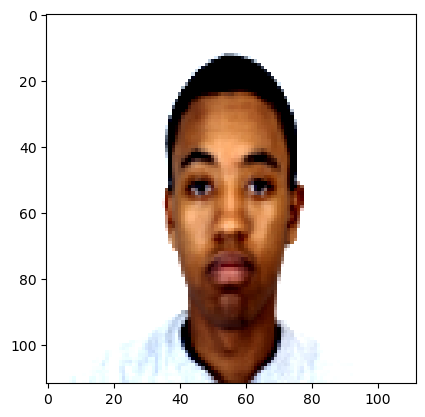

tensor(0) tensor(0) tensor(1)


In [6]:
tempIter = iter(testloader)
images,labels = next(tempIter)
imshow(images[0])
print(labels['age'][0],labels['gender'][0],labels['ethnicity'][0])

In [7]:
from collections import namedtuple
import torch
import torch.nn as nn
from torch.nn import Dropout
from torch.nn import MaxPool2d
from torch.nn import Sequential
from torch.nn import Conv2d, Linear
from torch.nn import BatchNorm1d, BatchNorm2d
from torch.nn import ReLU, Sigmoid
from torch.nn import Module
from torch.nn import PReLU
import os

def build_model(model_name='ir_50'):
    if model_name == 'ir_101':
        return IR_101(input_size=(112,112))
    elif model_name == 'ir_50':
        return IR_50(input_size=(112,112))
    elif model_name == 'ir_se_50':
        return IR_SE_50(input_size=(112,112))
    elif model_name == 'ir_34':
        return IR_34(input_size=(112,112))
    elif model_name == 'ir_18':
        return IR_18(input_size=(112,112))
    else:
        raise ValueError('not a correct model name', model_name)

def initialize_weights(modules):
    """ Weight initilize, conv2d and linear is initialized with kaiming_normal
    """
    for m in modules:
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight,
                                    mode='fan_out',
                                    nonlinearity='relu')
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight,
                                    mode='fan_out',
                                    nonlinearity='relu')
            if m.bias is not None:
                m.bias.data.zero_()


class Flatten(Module):
    """ Flat tensor
    """
    def forward(self, input):
        return input.view(input.size(0), -1)


class LinearBlock(Module):
    """ Convolution block without no-linear activation layer
    """
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(LinearBlock, self).__init__()
        self.conv = Conv2d(in_c, out_c, kernel, stride, padding, groups=groups, bias=False)
        self.bn = BatchNorm2d(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class GNAP(Module):
    """ Global Norm-Aware Pooling block
    """
    def __init__(self, in_c):
        super(GNAP, self).__init__()
        self.bn1 = BatchNorm2d(in_c, affine=False)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn2 = BatchNorm1d(in_c, affine=False)

    def forward(self, x):
        x = self.bn1(x)
        x_norm = torch.norm(x, 2, 1, True)
        x_norm_mean = torch.mean(x_norm)
        weight = x_norm_mean / x_norm
        x = x * weight
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        feature = self.bn2(x)
        return feature


class GDC(Module):
    """ Global Depthwise Convolution block
    """
    def __init__(self, in_c, embedding_size):
        super(GDC, self).__init__()
        self.conv_6_dw = LinearBlock(in_c, in_c,
                                     groups=in_c,
                                     kernel=(7, 7),
                                     stride=(1, 1),
                                     padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(in_c, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size, affine=False)

    def forward(self, x):
        x = self.conv_6_dw(x)
        x = self.conv_6_flatten(x)
        x = self.linear(x)
        x = self.bn(x)
        return x


class SEModule(Module):
    """ SE block
    """
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = Conv2d(channels, channels // reduction,
                          kernel_size=1, padding=0, bias=False)

        nn.init.xavier_uniform_(self.fc1.weight.data)

        self.relu = ReLU(inplace=True)
        self.fc2 = Conv2d(channels // reduction, channels,
                          kernel_size=1, padding=0, bias=False)

        self.sigmoid = Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return module_input * x



class BasicBlockIR(Module):
    """ BasicBlock for IRNet
    """
    def __init__(self, in_channel, depth, stride):
        super(BasicBlockIR, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride, bias=False),
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
            BatchNorm2d(depth),
            PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
            BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)

        return res + shortcut


class BottleneckIR(Module):
    """ BasicBlock with bottleneck for IRNet
    """
    def __init__(self, in_channel, depth, stride):
        super(BottleneckIR, self).__init__()
        reduction_channel = depth // 4
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride, bias=False),
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, reduction_channel, (1, 1), (1, 1), 0, bias=False),
            BatchNorm2d(reduction_channel),
            PReLU(reduction_channel),
            Conv2d(reduction_channel, reduction_channel, (3, 3), (1, 1), 1, bias=False),
            BatchNorm2d(reduction_channel),
            PReLU(reduction_channel),
            Conv2d(reduction_channel, depth, (1, 1), stride, 0, bias=False),
            BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)

        return res + shortcut


class BasicBlockIRSE(BasicBlockIR):
    def __init__(self, in_channel, depth, stride):
        super(BasicBlockIRSE, self).__init__(in_channel, depth, stride)
        self.res_layer.add_module("se_block", SEModule(depth, 16))


class BottleneckIRSE(BottleneckIR):
    def __init__(self, in_channel, depth, stride):
        super(BottleneckIRSE, self).__init__(in_channel, depth, stride)
        self.res_layer.add_module("se_block", SEModule(depth, 16))


class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
    '''A named tuple describing a ResNet block.'''


def get_block(in_channel, depth, num_units, stride=2):

    return [Bottleneck(in_channel, depth, stride)] +\
           [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
    if num_layers == 18:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=2),
            get_block(in_channel=64, depth=128, num_units=2),
            get_block(in_channel=128, depth=256, num_units=2),
            get_block(in_channel=256, depth=512, num_units=2)
        ]
    elif num_layers == 34:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=6),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 50:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=14),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 100:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=13),
            get_block(in_channel=128, depth=256, num_units=30),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 152:
        blocks = [
            get_block(in_channel=64, depth=256, num_units=3),
            get_block(in_channel=256, depth=512, num_units=8),
            get_block(in_channel=512, depth=1024, num_units=36),
            get_block(in_channel=1024, depth=2048, num_units=3)
        ]
    elif num_layers == 200:
        blocks = [
            get_block(in_channel=64, depth=256, num_units=3),
            get_block(in_channel=256, depth=512, num_units=24),
            get_block(in_channel=512, depth=1024, num_units=36),
            get_block(in_channel=1024, depth=2048, num_units=3)
        ]

    return blocks


class Backbone(Module):
    def __init__(self, input_size, num_layers, mode='ir'):
        """ Args:
            input_size: input_size of backbone
            num_layers: num_layers of backbone
            mode: support ir or irse
        """
        super(Backbone, self).__init__()
        assert input_size[0] in [112, 224], \
            "input_size should be [112, 112] or [224, 224]"
        assert num_layers in [18, 34, 50, 100, 152, 200], \
            "num_layers should be 18, 34, 50, 100 or 152"
        assert mode in ['ir', 'ir_se'], \
            "mode should be ir or ir_se"
        self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1, bias=False),
                                      BatchNorm2d(64), PReLU(64))
        blocks = get_blocks(num_layers)
        if num_layers <= 100:
            if mode == 'ir':
                unit_module = BasicBlockIR
            elif mode == 'ir_se':
                unit_module = BasicBlockIRSE
            output_channel = 512
        else:
            if mode == 'ir':
                unit_module = BottleneckIR
            elif mode == 'ir_se':
                unit_module = BottleneckIRSE
            output_channel = 2048

        if input_size[0] == 112:
            self.output_layer = Sequential(BatchNorm2d(output_channel),
                                        Dropout(0.4), Flatten(),
                                        Linear(output_channel * 7 * 7, 512),
                                        BatchNorm1d(512, affine=False))
        else:
            self.output_layer = Sequential(
                BatchNorm2d(output_channel), Dropout(0.4), Flatten(),
                Linear(output_channel * 14 * 14, 512),
                BatchNorm1d(512, affine=False))

        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(
                    unit_module(bottleneck.in_channel, bottleneck.depth,
                                bottleneck.stride))
        self.body = Sequential(*modules)

        initialize_weights(self.modules())


    def forward(self, x):
        
        # current code only supports one extra image
        # it comes with a extra dimension for number of extra image. We will just squeeze it out for now
        x = self.input_layer(x)

        for idx, module in enumerate(self.body):
            x = module(x)

        x = self.output_layer(x)
        norm = torch.norm(x, 2, 1, True)
        output = torch.div(x, norm)

        return output, norm



def IR_18(input_size):
    """ Constructs a ir-18 model.
    """
    model = Backbone(input_size, 18, 'ir')

    return model


def IR_34(input_size):
    """ Constructs a ir-34 model.
    """
    model = Backbone(input_size, 34, 'ir')

    return model


def IR_50(input_size):
    """ Constructs a ir-50 model.
    """
    model = Backbone(input_size, 50, 'ir')

    return model


def IR_101(input_size):
    """ Constructs a ir-101 model.
    """
    model = Backbone(input_size, 100, 'ir')

    return model


def IR_152(input_size):
    """ Constructs a ir-152 model.
    """
    model = Backbone(input_size, 152, 'ir')

    return model


def IR_200(input_size):
    """ Constructs a ir-200 model.
    """
    model = Backbone(input_size, 200, 'ir')

    return model


def IR_SE_50(input_size):
    """ Constructs a ir_se-50 model.
    """
    model = Backbone(input_size, 50, 'ir_se')

    return model


def IR_SE_101(input_size):
    """ Constructs a ir_se-101 model.
    """
    model = Backbone(input_size, 100, 'ir_se')

    return model


def IR_SE_152(input_size):
    """ Constructs a ir_se-152 model.
    """
    model = Backbone(input_size, 152, 'ir_se')

    return model


def IR_SE_200(input_size):
    """ Constructs a ir_se-200 model.
    """
    model = Backbone(input_size, 200, 'ir_se')

    return model


adaface_models = {
    'ir_18':"/home/csgrad/byalavar/FHE/HEAAN/FA_CVPR_Exp/adaface_ir18_webface4m.ckpt",
}


def load_pretrained_model(architecture='ir_18'):
    # load model and pretrained statedict
    assert architecture in adaface_models.keys()
    model = build_model(architecture)
    statedict = torch.load(adaface_models[architecture])['state_dict']
    model_statedict = {key[6:]:val for key, val in statedict.items() if key.startswith('model.')}
    model.load_state_dict(model_statedict)
    model.eval()
    return model

def to_input(pil_rgb_image):
    np_img = np.array(pil_rgb_image)
    brg_img = ((np_img[:,:,::-1] / 255.) - 0.5) / 0.5
    tensor = torch.tensor([brg_img.transpose(2,0,1)]).float()
    return tensor

In [8]:
adaFaceModel = load_pretrained_model('ir_18')

print(images.shape)
bgr_image = images[:, [2, 1, 0], :, :]
print(bgr_image.shape)


#feature, _ = adaFaceModel(bgr_image)

torch.Size([64, 3, 112, 112])
torch.Size([64, 3, 112, 112])


In [9]:
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore DeprecationWarnings
warnings.filterwarnings("ignore", category=FutureWarning) 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print('Running on device: {}'.format(device))

Running on device: cuda:1


In [12]:
import math
import numpy
def generate_C(C_range, m):
    """ Randomly generates m coefficients for the PolyProtect mapping.

    **Inputs:**

    C_range : integer
        The absolute min/max values of the coefficients range.

    m : int
        The number of coefficients to generate.

    **Outputs:**

    C : 1D numpy array of integers
        Array of m coefficients.

    """

    # Calculate coefficient range (excluding 0):
    neg_range = numpy.arange(-1 * C_range, 0)
    pos_range = numpy.arange(1, C_range + 1)
    whole_range = numpy.concatenate([neg_range, pos_range])

    # Randomly generate m unique coefficients:
    C = numpy.random.permutation(whole_range)[0 : m] # randomly permute the whole range and pick the first few m values

    return C


def generate_E(m):
    """ Randomly generates m exponents for the PolyProtect mapping.

    **Inputs:**

    m : int
        The number of exponents to generate.

    **Outputs:**

    E : 1D numpy array of integers
        Array of m exponents.

    """

    # Randomly generate m unique exponents:
    E = numpy.random.permutation(range(1, m + 1))[0 : m] # permute the integers in the range [1, m]

    return E


def polyprotect(overlap, V):
    """ Maps an embedding to a PolyProtected template.

    **Inputs:**

    overlap : int
        The amount of overlap between sets of embedding elements used to generate each PolyProtected element (0, 1, 2, 3, or 4).

    V : torch.Tensor
        The embedding as a PyTorch tensor.

    **Outputs:**

    P : torch.Tensor
        The PolyProtected template as a PyTorch tensor.

    """

    C = torch.tensor([-42, -35, 31, 4], dtype=torch.float32, device=V.device)
    E = torch.tensor([3, 2, 1, 4], dtype=torch.float32, device=V.device)
    # C = torch.tensor(generate_C(50,5),dtype=torch.float32,device=V.device)
    # E = torch.tensor(generate_E(5),dtype=torch.float32,device=V.device)

    if C.shape[0] != E.shape[0]:
        print("Number of coefficients and exponents must be the same.")
        return None
    #print("here")
    m = C.shape[0]  # number of embedding elements used to generate each PolyProtected element
    step_size = m - overlap 
    decimal_remainder, integer = math.modf((V.shape[0] - m) / step_size)
    if decimal_remainder > 0:
        padding = math.ceil((1 - decimal_remainder) * step_size)
    else:
        padding = 0
   # print("here1")
    # Pad V by "padding" zeros at the end
    V = torch.cat((V, torch.zeros(padding, device=V.device)), dim=0)

    starting_indices = torch.arange(0, V.shape[0] - m + 1, step_size)
    #print("here2")
    P = torch.zeros(len(starting_indices), device=V.device)
    
    for storage_ind, ind in enumerate(starting_indices):
        
        final_ind = ind + m
        crnt_word = V[ind:final_ind]
        P[storage_ind] = torch.sum(C * (crnt_word ** E))
    #print("here3")
    return P

In [13]:

class faceAnalytics(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.layer1=nn.Sequential(nn.Linear(128,512),nn.Dropout(0.5),nn.ReLU(),nn.Linear(512,256))
        
        self.dropout1=nn.Dropout(0.5)
        self.layer2=nn.Linear(256,128)
        #self.layer3=nn.Linear(1024,512)
        self.layer4=nn.Linear(128,64)
        self.dropout2=nn.Dropout(0.5)
        self.genderOut=nn.Sequential(nn.Linear(64,32),nn.ReLU(),nn.Linear(32,2))
        self.ageOut=nn.Linear(64,4)
        self.ethnicityOut = nn.Linear(64,4)

        # self.maxVal = 0
        # self.min=0
        
    
    def writeResult(self,result):
       output_directory=""
       file_name = "resultAge.txt"

       with open(os.path.join(output_directory, file_name), "w") as file:
        for value in result:
            file.write(f"{value}\n")
    
    def forward(self,x):

        #print("Input",x[0])
        x=self.layer1(x)
        #x=nn.functional.tanh(x)
        #print(x[0])
        #x=nn.functional.relu(x)
        #x=self.dropout1(x)
        #x=nn.functional.relu(x)
        x=self.layer2(x)
        #x=nn.functional.relu(x)
        #self.writeResult(x[0])
       # x=self.layer3(x)
        x=self.layer4(x)
        #print(torch.max(torch.abs(x)))
        #x=nn.functional.relu(x)
        
        x=self.dropout2(x)
        gender=self.genderOut(x)
        #gender = nn.functional.relu(gender)
        age=self.ageOut(x)

        ethn = self.ethnicityOut(x)
        #self.writeResult(age[0])
        #print(gender)
        return gender,age,ethn
    
    
    def are_values_in_same_class(self,value1, value2):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        for class_range in class_ranges:
            if class_range[0] <= value1 < class_range[1] and class_range[0] <= value2 < class_range[1]:
                return True
    
        return False    
    

    def trainModel(self,trainloader,testloader,adaFace,device,episodes):
        self.train()
        #maxVal = 0
        learningRate=0.005
        gender_loss = nn.CrossEntropyLoss() 
        age_loss = nn.CrossEntropyLoss() 
        ethn_loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learningRate)
        # optimizer = torch.optim.SGD(self.parameters(), lr=learningRate,
        # momentum=0.9, weight_decay=5e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=episodes)
        trainingAcc = []
        for e in range(0,episodes):
         total_training_loss =0
         genderAcc=0
         ethnAcc = 0
         ageAcc=0
         count=0
         totalGenderLoss=0
    
         batchSize = 256
         
        #  ageLabelTensor = ageLabelTensor.type(torch.LongTensor)
        #  genderLabelTensor = genderLabelTensor.type(torch.LongTensor)
        #  ethnLabelTensor = ethnLabelTensor.type(torch.LongTensor)

        #  while(count<tempPT.shape[0]):
        #     if(count+batchSize<=tempPT.shape[0]):
        #      inputs = tempPT[count:count+batchSize].to(device=device)
        #      age_label = ageLabelTensor[count:count+batchSize].to(device=device)
        #      gender_label = genderLabelTensor[count:count+batchSize].to(device=device)
        #      ethn_label = ethnLabelTensor[count:count+batchSize].to(device=device)
        #     else:
        #        inputs = tempPT[count:].to(device=device)
        #        age_label = ageLabelTensor[count:].to(device=device)
        #        gender_label = genderLabelTensor[count:].to(device=device)
        #        ethn_label = ethnLabelTensor[count:].to(device=device)
           
        #     gender,age,ethn = self(inputs)
            # age=torch.squeeze(age)
            # age=age.type(torch.float32)
            #print(age.shape,age_label.shape)
            #print(gender.shape,gender_label.shape)
            # predictedGender = torch.argmax(gender,dim=1)
            # predictedGender = predictedGender.type(torch.float32)
            #print(gender)



            
         for i,data in enumerate(trainloader):
    
            inputs = data[0].to(device=device)
            #inputs = inputs.type(torch.double)
            age_label = data[1]['age'].to(device=device)
            gender_label = data[1]['gender'].to(device=device)
            ethn_label = data[1]['ethnicity'].to(device=device)

            embeddings,_ = adaFace(inputs)
            
            inputUpdated = torch.zeros((embeddings.shape[0], 128),device=device)
            for t in range(0,embeddings.shape[0]):
             #print(inputs[t].shape,"inputs[t]")   
             inputUpdated[t] = polyprotect(0,embeddings[t])

            gender,age,ethn = self(inputUpdated)

            ageLoss = age_loss(age,age_label)
           
            loss = 3*gender_loss(gender,gender_label) + ageLoss + 2*ethn_loss(ethn,ethn_label) 
            #print(gender)
            #print(gender_label)
            #totalGenderLoss = totalGenderLoss + loss.item()
            loss.backward()
            #print("Loss:",loss)
            optimizer.step()
            optimizer.zero_grad()
            #total_training_loss = total_training_loss+loss.item()*512

            predictedGender = torch.argmax(gender,dim=1)
            predictedEthn = torch.argmax(ethn,dim=1)
            predictedAge = torch.argmax(age,dim=1)
            #print(predictedGender)
            #print(gender_label)
            for j in range(0,predictedGender.shape[0]):
                count=count+1
                #print(predictedGender[j].item(),gender_label[j])
                if(predictedGender[j].item()==gender_label[j].item()):
                    genderAcc=genderAcc+1
            
                if(predictedEthn[j].item()==ethn_label[j].item()):
                    ethnAcc=ethnAcc+1
  
                if(predictedAge[j].item()==age_label[j].item()):
                    ageAcc=ageAcc+1
  
         genderAccuracy =  genderAcc/count
         trainingAcc.append(genderAccuracy)
         print("Gender Accuracy:", genderAccuracy,"Age Acc:", ageAcc/count, " ethnAcc:", ethnAcc/count)
         #print("total training loss:",total_training_loss/16595,"\n")
         #print("\n")
         #scheduler.step()
         #print("max observed value: ", maxVal)
         if(e%2==0):
          self.test(testloader,adaFace,device)
             
        return trainingAcc

    def are_values_in_same_class(self,value1, value2):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        for class_range in class_ranges:
            if class_range[0] <= value1 < class_range[1] and class_range[0] <= value2 < class_range[1]:
                return True
    
        return False

    def test(self,testloader,adaFace,device):

         self.eval()
         age_loss = nn.L1Loss()

         totalAgeError = 0
         genderAccuracy = 0
         tempAcc=0
         count=0
         totalGenderLoss=0
         maxAge = 0
         minAge = 0
         ageAccuracy = 0
         total_training_loss =0
         tempAcc=0
         count=0
         totalGenderLoss=0

         genderAcc=0
         ethnAcc = 0
         
         batchSize = 128

         for i,data in enumerate(testloader):
    
            inputs = data[0].to(device=device)
            #inputs = inputs.type(torch.double)
            age_label = data[1]['age'].to(device=device)
            gender_label = data[1]['gender'].to(device=device)
            ethn_label = data[1]['ethnicity'].to(device=device)

            embeddings,_ = adaFace(inputs)
            
            inputUpdated = torch.zeros((embeddings.shape[0], 128),device=device)
            for t in range(0,embeddings.shape[0]):
             #print(inputs[t].shape,"inputs[t]")   
             inputUpdated[t] = polyprotect(0,embeddings[t])

            gender,age,ethn = self(inputUpdated)
         

            predictedGender = torch.argmax(gender,dim=1)
            predictedEthn = torch.argmax(ethn,dim=1)
            predictedAge = torch.argmax(age,dim=1)
            #age = get_original_age_value(age)

            for j in range(0,predictedGender.shape[0]):
                count=count+1
                #print(predictedGender[j].item(),gender_label[j])
                if(predictedGender[j].item()==gender_label[j]):
                    genderAcc=genderAcc+1
                if(predictedEthn[j].item()==ethn_label[j]):
                    ethnAcc=ethnAcc+1
                if(predictedAge[j].item()==age_label[j]):
                   ageAccuracy = ageAccuracy +1

         genderAccuracy =  genderAcc/count
         
         print("Gender Accuracy:", genderAccuracy,"Age Accuracy:", ageAccuracy/count, " ethnAcc:", ethnAcc/count)

         return genderAccuracy,totalAgeError
            
       

In [14]:
model=faceAnalytics()
model.to(device)
adaFaceModel.to(device)
adaFaceModel.eval()
trainingAcc = model.trainModel(trainloader,testloader,adaFaceModel,device,15)
#torch.save(model,"bestFaceAn.pt")

Gender Accuracy: 0.5052410901467506 Age Acc: 0.7924528301886793  ethnAcc: 0.27882599580712786
Gender Accuracy: 0.525 Age Accuracy: 0.825  ethnAcc: 0.3333333333333333
Gender Accuracy: 0.6771488469601677 Age Acc: 0.8532494758909853  ethnAcc: 0.46750524109014674
Gender Accuracy: 0.7484276729559748 Age Acc: 0.8532494758909853  ethnAcc: 0.5345911949685535
Gender Accuracy: 0.7833333333333333 Age Accuracy: 0.825  ethnAcc: 0.375
Gender Accuracy: 0.8113207547169812 Age Acc: 0.8469601677148847  ethnAcc: 0.559748427672956
Gender Accuracy: 0.8155136268343816 Age Acc: 0.8532494758909853  ethnAcc: 0.6142557651991615
Gender Accuracy: 0.7916666666666666 Age Accuracy: 0.825  ethnAcc: 0.525
Gender Accuracy: 0.8301886792452831 Age Acc: 0.8406708595387841  ethnAcc: 0.6226415094339622
Gender Accuracy: 0.8322851153039832 Age Acc: 0.8385744234800838  ethnAcc: 0.6310272536687631
Gender Accuracy: 0.775 Age Accuracy: 0.825  ethnAcc: 0.4583333333333333
Gender Accuracy: 0.8763102725366876 Age Acc: 0.8511530398322

In [63]:
model.test(testloader,arcFaceModel,device)

tensor([[35.3753],
        [34.8900],
        [35.9449],
        [35.1217],
        [35.7582],
        [35.6678],
        [35.2125],
        [36.1453],
        [35.4029],
        [35.2653],
        [35.0805],
        [35.3967],
        [35.5769],
        [35.7067],
        [35.9907],
        [35.8430],
        [35.9960],
        [35.7801],
        [36.0240],
        [35.3092],
        [34.7713],
        [35.2087],
        [35.2737],
        [34.7884],
        [34.8579],
        [35.5894],
        [35.0393],
        [35.1824],
        [35.2798],
        [35.3226],
        [34.7159],
        [34.9689],
        [34.7194],
        [34.5731],
        [35.1871],
        [34.6003],
        [35.5002],
        [35.1668],
        [35.6073],
        [35.7567],
        [35.5327],
        [35.1987],
        [35.2451],
        [34.9374],
        [35.2929],
        [34.3929],
        [34.5153],
        [35.3669],
        [34.5637],
        [35.0643],
        [34.7852],
        [34.8137],
        [35.

KeyboardInterrupt: 

In [57]:
torch.save(model,"arcFaceCelebSetBase.pt")

In [30]:
torch.save(model,"negGenderBaseWiki.pt")

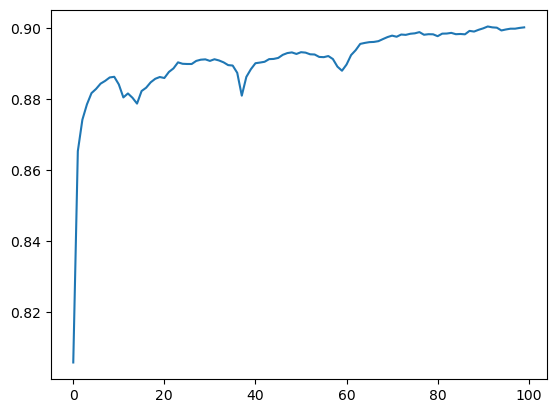

In [29]:
plt.plot(trainingAcc)

In [23]:
torch.save(model,"model92.pt")

In [24]:
count=0
input1=[]
for i,data in enumerate(val_dataloader):
    
    if(count==0):
     inputs=resnet(data["image"].to(device))

 
     input1 = polyprotect(0,inputs[0])

     break
    count=count+1

In [25]:
input1

tensor([-1.4430, -1.9958, -0.6684,  1.0280, -1.1776,  0.5820,  1.1919, -1.2120,
         0.5127, -0.1822,  0.6574, -1.9295,  1.2562, -1.0405, -1.5425, -2.9240,
         0.8135,  1.8771,  0.7530, -0.4737,  2.3692, -1.3006, -1.7764, -1.7158,
        -1.2634,  0.7241,  1.4031, -2.1193,  0.3556,  0.8521, -2.6465, -1.6996,
        -0.3830,  0.5889, -1.5234,  0.5707, -0.4224, -1.3535, -1.2482, -2.5428,
        -0.5712, -0.3220,  0.3134,  1.0675, -2.0277, -0.0984,  0.9127, -0.8203,
         0.5162,  0.8371,  0.2184,  1.7868,  0.1441,  2.2517,  0.9456,  0.2534,
        -2.4333, -1.6649,  0.5323, -0.8450,  0.6767, -1.2998,  0.1268, -1.4707,
        -1.2234, -3.1957, -0.3958,  2.0446, -1.4466,  1.2428, -0.1448,  1.3427,
        -0.7067, -1.0655, -1.0468, -4.1246,  1.0056, -1.1438, -0.4887,  1.7819,
        -0.3919, -1.5383,  3.3167,  0.0240, -0.7870, -2.7450, -2.3516, -0.2413,
        -1.3294, -2.1587, -1.5163,  1.6668, -0.6842, -1.0367, -1.9168,  0.2893,
        -1.6461, -0.0207, -0.1686,  1.37

In [30]:
for param in model.parameters():
    print(param.shape)
    print(param[0])
    print(torch.dot(input1,param[1]))
    break 

torch.Size([512, 128])
tensor([-0.0765, -0.1069, -0.0411,  0.0238,  0.0118,  0.0784, -0.0193, -0.0194,
        -0.0132,  0.0487,  0.0409, -0.0441, -0.1003,  0.0050,  0.0179,  0.0378,
        -0.0322,  0.0842, -0.0395, -0.0201,  0.0457, -0.0654, -0.0586,  0.0188,
        -0.0772,  0.0069,  0.0861, -0.0244,  0.0486, -0.0309, -0.0071,  0.0655,
        -0.1047,  0.0400,  0.0215, -0.0451,  0.0729, -0.0582, -0.0285,  0.0711,
        -0.0588, -0.0468, -0.0742, -0.0929,  0.0281,  0.0036, -0.0665, -0.0713,
        -0.0775,  0.0966,  0.0213,  0.0536, -0.0497, -0.0261,  0.0736, -0.0707,
        -0.0635,  0.0039,  0.0356,  0.0208, -0.0432,  0.0132,  0.0090, -0.0508,
         0.0649, -0.0474,  0.0852,  0.0400,  0.0783,  0.0792, -0.0682, -0.0400,
         0.0074, -0.0067,  0.0327,  0.0179, -0.0077, -0.0110,  0.0008,  0.0626,
         0.0268, -0.0395, -0.0766,  0.0686, -0.0601,  0.0466,  0.0655,  0.0477,
        -0.0761,  0.0306,  0.0702, -0.0810,  0.0598,  0.0180, -0.0715, -0.0503,
        -0.0228, 

In [69]:
input1

tensor([-1.4430, -1.9958, -0.6684,  1.0280, -1.1776,  0.5820,  1.1919, -1.2120,
         0.5127, -0.1822,  0.6574, -1.9295,  1.2562, -1.0405, -1.5425, -2.9240,
         0.8135,  1.8771,  0.7530, -0.4737,  2.3692, -1.3006, -1.7764, -1.7158,
        -1.2634,  0.7241,  1.4031, -2.1193,  0.3556,  0.8521, -2.6465, -1.6996,
        -0.3830,  0.5889, -1.5234,  0.5707, -0.4224, -1.3535, -1.2482, -2.5428,
        -0.5712, -0.3220,  0.3134,  1.0675, -2.0277, -0.0984,  0.9127, -0.8203,
         0.5162,  0.8371,  0.2184,  1.7868,  0.1441,  2.2517,  0.9456,  0.2534,
        -2.4333, -1.6649,  0.5323, -0.8450,  0.6767, -1.2998,  0.1268, -1.4707,
        -1.2234, -3.1957, -0.3958,  2.0446, -1.4466,  1.2428, -0.1448,  1.3427,
        -0.7067, -1.0655, -1.0468, -4.1246,  1.0056, -1.1438, -0.4887,  1.7819,
        -0.3919, -1.5383,  3.3167,  0.0240, -0.7870, -2.7450, -2.3516, -0.2413,
        -1.3294, -2.1587, -1.5163,  1.6668, -0.6842, -1.0367, -1.9168,  0.2893,
        -1.6461, -0.0207, -0.1686,  1.37

In [72]:
output_directory=""
file_name = "input1.txt"

with open(os.path.join(output_directory, file_name), "w") as file:
        for value in input1:
            file.write(f"{value}\n")

In [103]:
model=faceAnalytics()
model=torch.load("/home/csgrad/byalavar/FHE/HEAAN/modelUsing0.pt")
model.to(device)
model.test(dataloader,device)

ageAccuracy:  0.638671875
ageAccuracy:  0.62109375
ageAccuracy:  0.6087239583333334
ageAccuracy:  0.6162109375
ageAccuracy:  0.626953125
ageAccuracy:  0.6259765625
ageAccuracy:  0.62890625
ageAccuracy:  0.628662109375
ageAccuracy:  0.6271701388888888
ageAccuracy:  0.6259765625
ageAccuracy:  0.6296164772727273
ageAccuracy:  0.6300455729166666
ageAccuracy:  0.6275540865384616
ageAccuracy:  0.6256975446428571
ageAccuracy:  0.62578125
ageAccuracy:  0.627197265625
ageAccuracy:  0.6246553308823529
ageAccuracy:  0.6252170138888888
ageAccuracy:  0.6258223684210527
ageAccuracy:  0.62392578125
ageAccuracy:  0.6255580357142857
ageAccuracy:  0.6242009943181818
ageAccuracy:  0.6240658967391305
ageAccuracy:  0.624267578125
ageAccuracy:  0.6246875
ageAccuracy:  0.6246995192307693
ageAccuracy:  0.6237702546296297
ageAccuracy:  0.6241629464285714
ageAccuracy:  0.6245285560344828
ageAccuracy:  0.6251953125
ageAccuracy:  0.6246219758064516
ageAccuracy:  0.62457275390625
ageAccuracy:  0.6244081439393939
a

(0.9118510045752934, 4815.783493041992)

In [38]:
torch.save(model,"modelUsing0.pt")

In [82]:
count=0
for param in model.parameters():
    print(param.shape)
    count=count+1
    if(count==2):
        print(param)

torch.Size([512, 128])
torch.Size([512])
Parameter containing:
tensor([-0.0608, -0.0217,  0.0529, -0.0089,  0.0091,  0.0046, -0.0850,  0.0737,
         0.0143,  0.0217, -0.0977,  0.0810, -0.0564,  0.0011,  0.0722, -0.0247,
         0.0400, -0.0504, -0.0266,  0.0041,  0.0306, -0.0060, -0.0088, -0.0187,
         0.0724, -0.0828, -0.0848, -0.0345, -0.0290,  0.0105,  0.0145, -0.0039,
        -0.0052, -0.0191,  0.0698, -0.0620, -0.0487, -0.1063,  0.0467, -0.0002,
         0.0537,  0.0358, -0.0329,  0.0654, -0.0006, -0.1011, -0.0192, -0.0640,
        -0.0694,  0.0320, -0.1085,  0.0418, -0.0238, -0.0615, -0.0560,  0.0657,
        -0.0512,  0.0451, -0.0391,  0.0244, -0.0777, -0.0340,  0.0475,  0.0886,
         0.0003, -0.0109, -0.0577, -0.0619, -0.0323, -0.0008, -0.0176,  0.0066,
         0.0504,  0.0278, -0.0135,  0.0303,  0.0313, -0.0311,  0.0308, -0.0487,
         0.0603, -0.0842,  0.0063, -0.0263,  0.0686,  0.0789,  0.0931,  0.0091,
        -0.0183, -0.0787,  0.0457,  0.0954,  0.0281, -0.0

In [52]:
a=nn.Linear(4,2)
input1=torch.rand((1,4))
print("input1",input1)
for param in a.parameters():
    print("param",param)
print(a(input1))


input1 tensor([[0.1725, 0.7784, 0.7692, 0.3667]])
param Parameter containing:
tensor([[ 0.0794, -0.2791,  0.0171, -0.2814],
        [-0.0677, -0.3197, -0.2683, -0.3466]], requires_grad=True)
param Parameter containing:
tensor([ 0.0877, -0.3602], requires_grad=True)
tensor([[-0.2058, -0.9542]], grad_fn=<AddmmBackward0>)


In [70]:
model=faceAnalytics()
model=torch.load("modelUsing0.pt")
model.to(device)
count=0
ageBias=[]
for param in model.parameters(): 
    print(param.shape)
    if(count==7):
       ageBias = param.tolist()
    count=count+1
print(len(ageBias),len(ageBias[0]))


torch.Size([512, 128])
torch.Size([512])
torch.Size([128, 512])
torch.Size([128])
torch.Size([2, 128])
torch.Size([2])
torch.Size([1, 128])
torch.Size([1])


TypeError: object of type 'float' has no len()

In [71]:
ageBias

[0.09601110219955444]

In [41]:
bias2

[0.007277209311723709,
 -0.0321158841252327,
 -0.031418390572071075,
 -0.006457424722611904,
 0.0034283681306988,
 0.018647771328687668,
 0.010360945016145706,
 -0.046598006039857864,
 -0.05573476478457451,
 0.01843833737075329,
 0.0027071069926023483,
 0.03294723108410835,
 0.02504689060151577,
 -0.03142755106091499,
 -0.022691987454891205,
 0.03483140096068382,
 -0.05341877415776253,
 0.04222894087433815,
 -0.01728733628988266,
 -0.04929398000240326,
 0.00046024261973798275,
 -0.044817082583904266,
 0.0034655649214982986,
 -0.03304927796125412,
 -0.0016231774352490902,
 -0.04087826982140541,
 0.01253503654152155,
 -0.030864598229527473,
 -0.013328468427062035,
 0.012476014904677868,
 -0.037187058478593826,
 0.006219789385795593,
 -0.013966446742415428,
 0.01565675437450409,
 0.0035794111900031567,
 -0.005585063714534044,
 0.006055895704776049,
 0.00048314392915926874,
 -0.010381164960563183,
 -0.018931696191430092,
 0.012918422929942608,
 0.014919551089406013,
 -0.015488061122596264,

In [68]:
# Create a list of lists with shape (512, 128)


# Define the directory where you want to save the text files
output_directory = "ageWeights"

# Create the output directory if it doesn't exist
import os
os.makedirs(output_directory, exist_ok=True)

# Write each list to a separate text file


# Write each list to a separate text file
for i, sublist in enumerate(ageWeights):
    # Define the file name with leading zeros
    file_name = f"{i:03d}.txt"

    # Write each value in the sublist on a new line
    with open(os.path.join(output_directory, file_name), "w") as file:
        for value in sublist:
            file.write(f"{value}\n")

print("Files saved successfully.")


Files saved successfully.


In [32]:
count=1
layer1Bias=[]
for param in model.parameters(): 
    print(param.shape)
    if(count==2):
       layer1Bias = param.tolist()
       break
    count=count+1
print(len(layer1Bias),len(layer1Bias[0]))

torch.Size([512, 128])
torch.Size([512])


TypeError: object of type 'float' has no len()

In [72]:
output_directory=""
file_name = "ageBias.txt"

with open(os.path.join(output_directory, file_name), "w") as file:
        for value in ageBias:
            file.write(f"{value}\n")